# Join Datasets
Access the data for Chloris and Planet, rename the columns, and join variables from both datasets into a single dataset. 

### Import required packages.

In [1]:
import snowflake.connector
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv

# Load environment variables.
load_dotenv()

True

### Connect to Snowflake and pull the data of interest.
The SQL query below demonstrates how to access variables from multiple datasets using aliases. In the example below, we use 'c' to refer to the Chloris dataset, and 'p' to refer to the Planet dataset. The full SQL query is broken down and explained below.

**SQL Query Breakdown:**

We begin by selecting all the variables we are interested in from both Chloris (indicated by 'c') and Planet (indicated by 'p'). Some of the variables are renamed using the SQL clause 'AS' (e.g. Chloris aboveground biomass is called 'STOCK' in the raw dataset, but in the example below, we rename it 'chloris_agb').
```SQL
    SELECT
        c.year,
        c.lon,
        c.lat,
        c.stock AS chloris_agb,
        p.aboveground_carbon_density AS planet_acd,
        p.canopy_cover AS planet_cc
```

Next, we use the SQL clause 'FROM' to indicate which dataset the variables should be pulled from. Note that we also define the alias 'c' to refer to the Chloris dataset here.
```SQL
    FROM
        chloris.forest_cover c
```

Finally, we perform an outer join with the Planet dataset (and define the dataset alias 'p'). To have the join perform as expected, we indicate which variables should be aligned between the two datasets. In this case, we expect all of the years and lat and lon values to match between the two datasets, so these are used as the fields on which the join is defined. At this point, we also define the year of data that we want returned using the clause 'WHERE'. 
```SQL
    FULL OUTER JOIN
        planet.pv_forest_carbon p
        ON
        c.year = p.year AND c.lon = p.lon AND c.lat = p.lat
    WHERE
        c.year = 2020
```

In [2]:
# Define the SQL query to get data from Chloris and Planet data for 2020.
sql_query = """
    SELECT
        c.year,
        c.lon,
        c.lat,
        c.stock AS chloris_agb,
        p.aboveground_carbon_density AS planet_acd,
        p.canopy_cover AS planet_cc
    FROM
        chloris.forest_cover c
    FULL OUTER JOIN
        planet.pv_forest_carbon p
        ON
        c.year = p.year AND c.lon = p.lon AND c.lat = p.lat
    WHERE
        c.year = 2020
    """

# Connect to database using information stored in config file and execute query.
with snowflake.connector.connect(
        account = os.getenv('DB_ACCOUNT'),
        warehouse = os.getenv('DB_WAREHOUSE'),
        database = os.getenv('DB_DATABASE'), 
        user = os.getenv('DB_USERNAME'),
        password = os.getenv('DB_PASSWORD')
) as conn:
    cur = conn.cursor().execute(sql_query)
    df = cur.fetch_pandas_all()

# Examine dataframe.
df.head(10)

,YEAR,LON,LAT,CHLORIS_AGB,PLANET_ACD,PLANET_CC
0,2020,-2.778625,57.123375,NaN,0.0,0.0
1,2020,-2.779125,57.122625,104.0,49.0,21.0
2,2020,-2.779625,57.122125,101.0,42.0,24.0
3,2020,-2.778875,57.122125,128.0,53.0,40.0
4,2020,-2.779875,57.121875,80.0,0.0,0.0
5,2020,-2.778125,57.121875,110.0,50.0,37.0
6,2020,-2.778375,57.121625,94.0,50.0,34.0
7,2020,-2.778875,57.121375,114.0,62.0,48.0
8,2020,-2.778375,57.121375,98.0,53.0,36.0
9,2020,-2.780625,57.121125,NaN,0.0,0.0


### Plot variables.

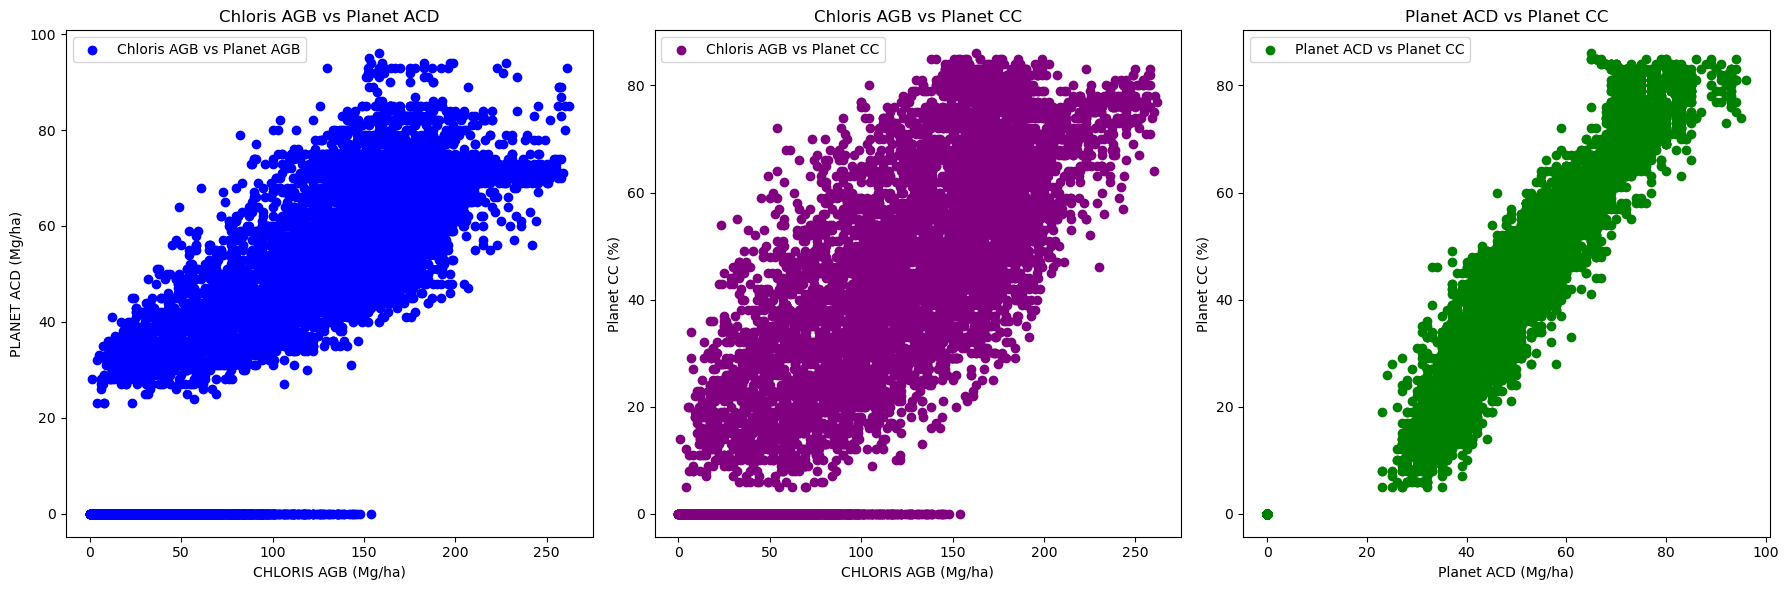

In [3]:
# Create a figure with 3 subplots to visualize joined dataset.
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Chloris AGB vs Planet ACD
axes[0].scatter(df['CHLORIS_AGB'], df['PLANET_ACD'], color='blue', label='Chloris AGB vs Planet AGB')
axes[0].set_xlabel('CHLORIS AGB (Mg/ha)')
axes[0].set_ylabel('PLANET ACD (Mg/ha)')
axes[0].set_title('Chloris AGB vs Planet ACD')
axes[0].legend()

# Plot 2: Chloris AGB vs Planet CC
axes[1].scatter(df['CHLORIS_AGB'], df['PLANET_CC'], color='purple', label='Chloris AGB vs Planet CC')
axes[1].set_xlabel('CHLORIS AGB (Mg/ha)')
axes[1].set_ylabel('Planet CC (%)')
axes[1].set_title('Chloris AGB vs Planet CC')
axes[1].legend()

# Plot 3: Planet ACD vs Planet CC
axes[2].scatter(df['PLANET_ACD'], df['PLANET_CC'], color='green', label='Planet ACD vs Planet CC')
axes[2].set_xlabel('Planet ACD (Mg/ha)')
axes[2].set_ylabel('Planet CC (%)')
axes[2].set_title('Planet ACD vs Planet CC')
axes[2].legend()

# Show the resulting plots.
plt.tight_layout()
plt.show()